# Text Compression: Semantic and Binary

- **Created by Andrés Segura Tinoco**  
- **Created on August 20, 2019**

In [1]:
# Load Python libraries
import io
import os
import pandas as pd
from collections import Counter
import locale

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Semantic Compression

In [3]:
# Get current encoding
locale.getdefaultlocale()

('en_US', 'cp1252')

In [4]:
# Util function to read a plain text file
def read_text_file(file_path):
    text = ""
    with io.open(file_path, 'r', encoding = 'ISO-8859-1') as f:
        text = f.read()
    return text;

In [5]:
# Loading target text book
file_path = "../data/text/book1-en.txt"
file_text = read_text_file(file_path)

In [6]:
# Weight of the original file
file_size = os.path.getsize(file_path)
print(round(file_size / 1024, 2), 'KB')

1227.64 KB


### NPL Preprocessing Approach

In [7]:
# Cleaing the text
clean_text = file_text.replace('\n', ' ')

In [8]:
# Tokenize text in words
word_list = clean_text.split(' ')
len(word_list)

216910

In [9]:
# Showing first 100 words
print(word_list[:100])

['ï»¿', 'The', 'Project', 'Gutenberg', 'EBook', 'of', 'Moby', 'Dick;', 'or', 'The', 'Whale,', 'by', 'Herman', 'Melville', '', 'This', 'eBook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever.', '', 'You', 'may', 'copy', 'it,', 'give', 'it', 'away', 'or', 're-use', 'it', 'under', 'the', 'terms', 'of', 'the', 'Project', 'Gutenberg', 'License', 'included', 'with', 'this', 'eBook', 'or', 'online', 'at', 'www.gutenberg.org', '', '', 'Title:', 'Moby', 'Dick;', 'or', 'The', 'Whale', '', 'Author:', 'Herman', 'Melville', '', 'Release', 'Date:', 'December', '25,', '2008', '[EBook', '#2701]', 'Last', 'Updated:', 'December', '3,', '2017', '', 'Language:', 'English', '', 'Character', 'set', 'encoding:', 'UTF-8', '', '***', 'START', 'OF', 'THIS', 'PROJECT', 'GUTENBERG']


In [10]:
# Count the words in a document and return the most N repeated
def count_words(word_list, n):
    words = Counter()
    
    for word in word_list:
        words[word] += 1
    
    return words.most_common(n)

In [11]:
# Get the most common words in the document
n_words = count_words(word_list, 1000)
df_words = pd.DataFrame.from_records(n_words, columns = ['word', 'quantity'])
df_words['comp_size'] = df_words.quantity * df_words.word.str.len()
df_words = df_words.sort_values(by=['comp_size'], ascending=False)
df_words.head(10)

,word,quantity,comp_size
0,the,13697,41091
2,and,5934,17802
1,of,6534,13068
7,that,2679,10716
4,to,4459,8918
6,in,3850,7700
8,his,2428,7284
10,with,1651,6604
12,was,1566,4698
19,this,1133,4532


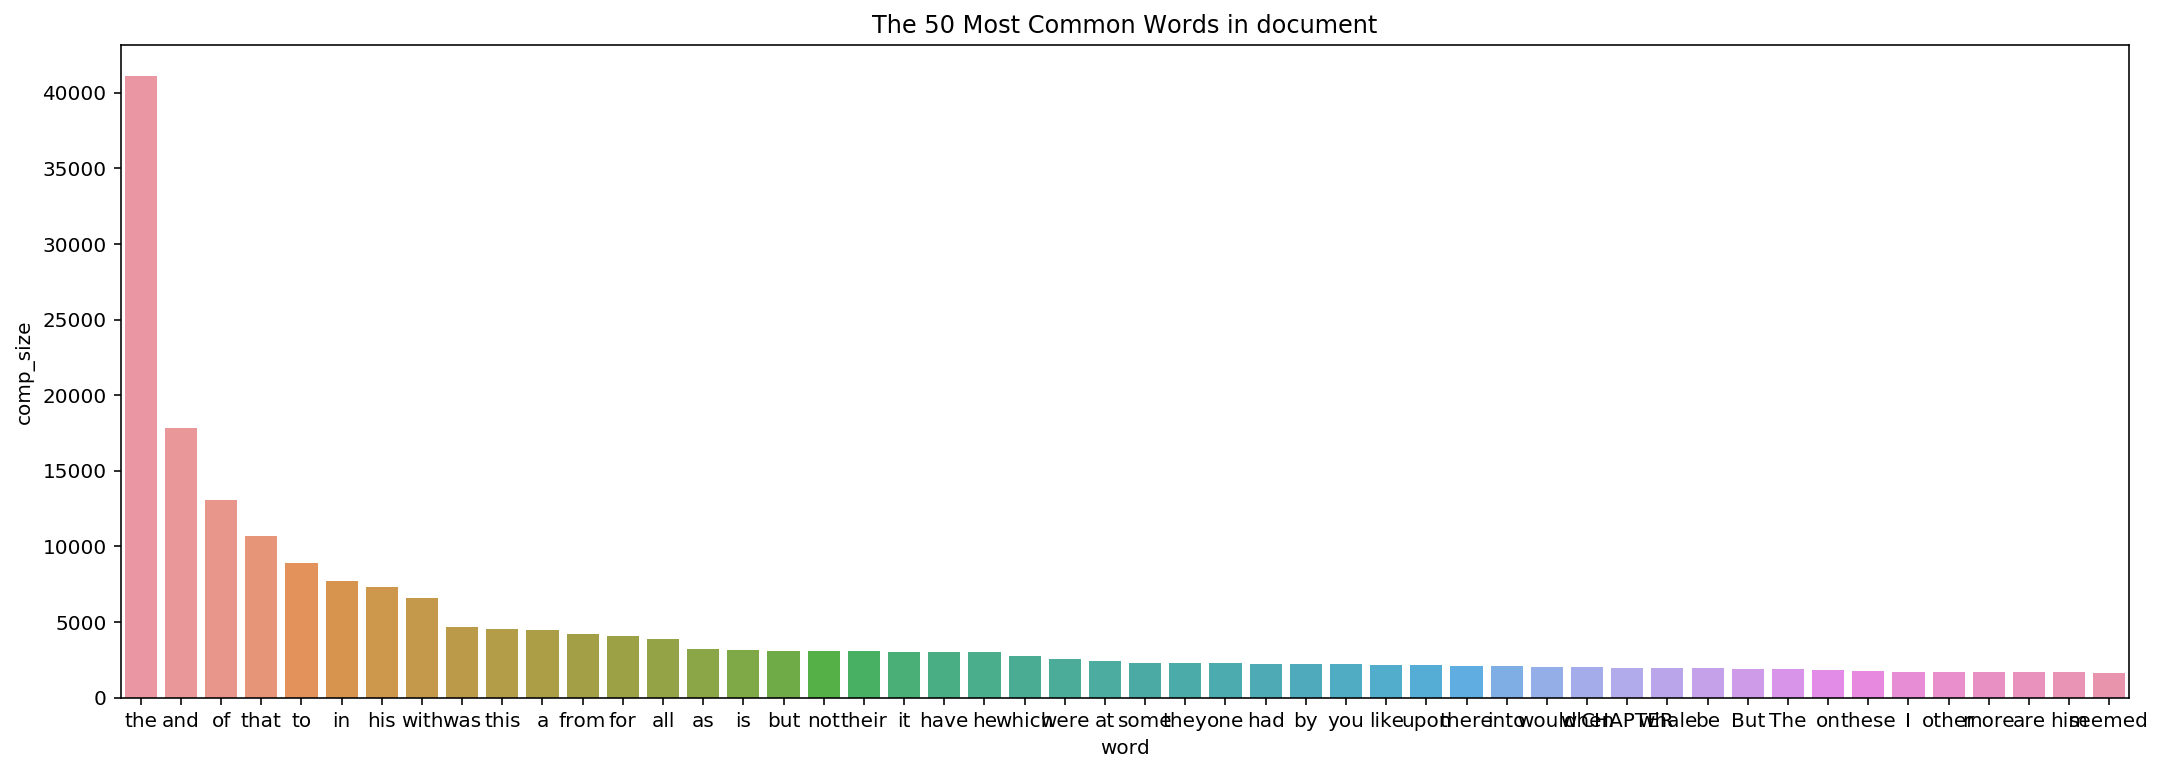

In [12]:
# Plot the most common words in the document
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = 'word', y = 'comp_size', data = df_words[0:50])
plt.title('The 50 Most Common Words in document')
plt.show()

**Next Step**

Once the words to be replaced are identified, unused symbols must be found in the alphabet, to be used as substituents.

In [13]:
# Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None;

In [14]:
# Loading target text book
file_byte_list = get_file_bytes(file_path)

In [15]:
# Calculate code frequency
term_freq = Counter(file_byte_list)
n = len(term_freq)
print('Used symbols:', n)

Used symbols: 110


In [16]:
# Normalize term frequency
max_bytes = 256

total = sum(term_freq.values())
for ix in range(max_bytes):
    if ix in term_freq:
        term_freq[ix] = term_freq[ix] / total
    else:
        term_freq[ix] = 0

In [17]:
# Create dataframe: unused byte list
df_ubytes = pd.DataFrame.from_records(term_freq.most_common(max_bytes), columns = ['Byte', 'Frequency'])
df_ubytes.head(10)

,Byte,Frequency
0,32,0.155075
1,101,0.092954
2,116,0.068523
3,97,0.060395
4,111,0.054837
5,110,0.051702
6,115,0.049752
7,105,0.049692
8,104,0.049322
9,114,0.041215


In [18]:
# Create pretty x axis labels
def get_x_labels():
    x_labels = []
    for ix in range(max_bytes):
        if ix % 5 == 0:
            x_labels.append(str(ix))
        else:
            x_labels.append('')
    return x_labels

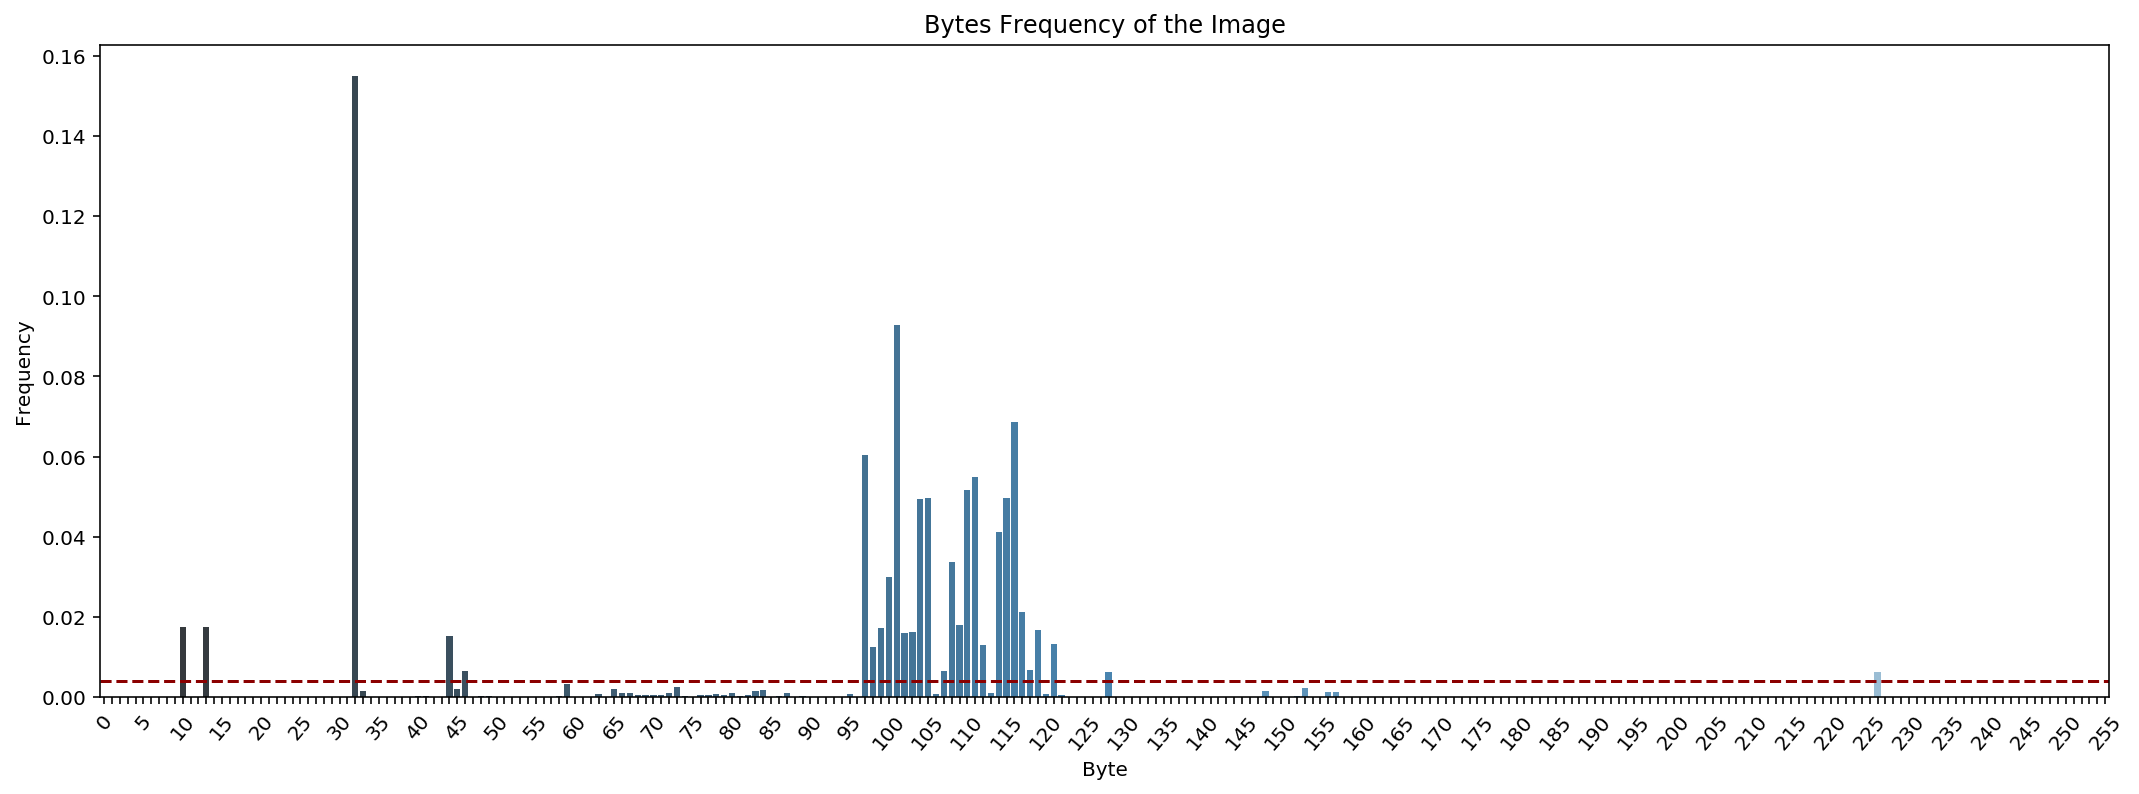

In [19]:
# Probability of each symbol by default
p_x = 1 / max_bytes

# Plot the frequency of the bytes in the file
fig = plt.figure(figsize = (18, 6))
ax = sns.barplot(x = 'Byte', y = 'Frequency', data = df_ubytes.sort_values(by=['Byte']), palette=("Blues_d"))
ax.set_xticklabels(labels = get_x_labels(), fontsize = 10, rotation = 50)
plt.axhline(y = p_x, color = "#8b0000", linestyle = "--")
plt.title('Bytes Frequency of the Image')
plt.show()

In [20]:
unused_symbols = list(df_ubytes[df_ubytes['Frequency'] == 0]["Byte"])
len(unused_symbols)

146

Now, we can replace the heaviest words with unused symbols in the file.

In [21]:
# Symbols replaced
symb_repleced = dict()
n_symb_repleced = min(150, len(unused_symbols))
ix = 0

for index, row in df_words.iterrows():
    if ix < n_symb_repleced:
        key = row['word']
        value = int(unused_symbols[ix])
        symb_repleced[key] = value
    else:
        break
    ix += 1
print(symb_repleced)

{'the': 0, 'and': 1, 'of': 2, 'that': 3, 'to': 4, 'in': 5, 'his': 6, 'with': 7, 'was': 8, 'this': 9, 'a': 11, 'from': 12, 'for': 14, 'all': 15, 'as': 16, 'is': 17, 'but': 18, 'not': 19, 'their': 20, 'it': 21, 'have': 22, 'he': 23, 'which': 24, 'were': 25, 'at': 26, 'some': 27, 'they': 28, 'one': 29, 'had': 30, 'by': 31, 'you': 34, 'like': 37, 'upon': 39, 'there': 43, 'into': 47, 'would': 60, 'when': 61, 'CHAPTER': 62, 'whale': 64, 'be': 92, 'But': 94, 'The': 96, 'on': 123, 'these': 124, 'I': 125, 'other': 126, 'more': 127, 'are': 129, 'him': 131, 'seemed': 133, 'though': 134, 'been': 135, 'so': 136, 'before': 137, 'what': 138, 'those': 139, 'through': 140, 'over': 141, 'great': 142, 'little': 143, 'or': 144, 'only': 145, 'still': 150, 'now': 154, 'about': 155, 'will': 158, 'then': 159, 'out': 160, 'such': 161, 'old': 164, 'than': 165, 'very': 167, 'down': 170, 'after': 171, 'an': 172, 'Captain': 173, 'three': 174, 'my': 175, 'its': 177, 'them': 178, 'most': 179, 'every': 180, 'almost':

### Apply Semantic Compression

In [22]:
file_comp_text = file_text
for key, value in symb_repleced.items():
    c_value = chr(value)
    file_comp_text = file_comp_text.replace(key, c_value)

In [23]:
file_path_comp = file_path.replace('.txt', '_comp.txt')
with open(file_path_comp, 'w', encoding = 'ISO-8859-1') as f:
    f.write(file_comp_text)

In [24]:
# Weight of the compressed file
file_size = os.path.getsize(file_path_comp)
print(round(file_size / 1024, 2), 'KB')

988.64 KB


In [25]:
# Original file
print('Number of characters:', len(file_text))

Number of characters: 1235134


In [26]:
# Compressed file
print('Number of characters:', len(file_comp_text))

Number of characters: 990399


In [27]:
# Semantic compression percentage
compress_rate =  (len(file_text) - len(file_comp_text)) / len(file_text)
print(round(compress_rate * 100, 2), '%')

19.81 %


### Showing new distribution

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>